In [1]:
import teneva as tn
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import QuantLib as ql
from numpy.polynomial.polynomial import Polynomial

In [2]:
use_cached_test_results = False

In [3]:
data_train = pd.read_csv("fdm_hagan_vol_train.csv")
data_test = pd.read_csv("fdm_hagan_vol_test.csv")

In [4]:
param_names = ["Strike", "Tenor", "Alpha", "Beta", "Nu", "Rho"]

In [5]:
class HaganDiffModel:

    def __init__(self, rank):
        self.rank = rank

    def hagan(self, X):
        return np.array([ql.sabrVolatility(row[0], 1, *row[1:]) for row in X])

    def train(self, X_trn, Y_trn):
        self.ranges = [np.unique(X_trn[:, i]) for i in range(6)]
        self.index_mappings = [{param : np.where(r == param)[0][0] for param in r} for r in self.ranges]
        I_trn = np.array([[self.index_mappings[i][row[i]] for i in range(6)] for row in X_trn])
        Y0 = tn.rand([len(r) for r in self.ranges], self.rank)
        self.tt = tn.als(I_trn, Y_trn - self.hagan(X_trn), Y0)
        self.get = tn.getter(self.tt)

    def predict(self, X):
        return np.array([self.get(np.array([self.index_mappings[i][row[i]] for i in range(6)])) for row in X]) + self.hagan(X)

    def __str__(self):
        return f"HaganDiffModel(rank = {self.rank})"

In [6]:
class HaganPolynomialModel(HaganDiffModel):

    def __init__(self, rank, polynomial_degrees):
        super().__init__(rank)
        self.polynomial_degrees = polynomial_degrees
    
    def train(self, X_trn, Y_trn):
        super().train(X_trn, Y_trn)
        self.polynomial_cores = []
        for dimen, core in enumerate(self.tt):
            polynomial_core = np.empty([core.shape[0], core.shape[2], self.polynomial_degrees[dimen]])
            for i in range(core.shape[0]):
                for j in range(core.shape[2]):
                    polynomial_core[i, j, :] = Polynomial.fit(self.ranges[dimen], core[i, :, j], self.polynomial_degrees[dimen] - 1).convert().coef
            self.polynomial_cores.append(polynomial_core)
    
    def predict(self, X):
        res = np.empty([X.shape[0]])
        for i, row in enumerate(X):
            product = np.array([1])
            for dimen, param in enumerate(row):
                product = product @ (self.polynomial_cores[dimen] @ np.power(param, np.arange(self.polynomial_degrees[dimen])))
            res[i] = product[0]
        return res + self.hagan(X)

    def __str__(self):
        return f"HaganPolynomialModel(rank = {self.rank}, polynomial_degrees = {self.polynomial_degrees})"

In [7]:
class FdmModel:

    def __init__(self, rank):
        self.rank = rank

    def train(self, X_trn, Y_trn):
        self.ranges = [np.unique(X_trn[:, i]) for i in range(6)]
        self.index_mappings = [{param : np.where(r == param)[0][0] for param in r} for r in self.ranges]
        I_trn = np.array([[self.index_mappings[i][row[i]] for i in range(6)] for row in X_trn])
        Y0 = tn.rand([len(r) for r in self.ranges], self.rank)
        self.tt = tn.als(I_trn, Y_trn, Y0)
        self.get = tn.getter(self.tt)

    def predict(self, X):
        return np.array([self.get(np.array([self.index_mappings[i][row[i]] for i in range(6)])) for row in X])

    def __str__(self):
        return f"FdmModel(rank = {self.rank})"

In [8]:
def run_test(model, num_samples_train, data, data_test=None, timed=False):
    print(f"Testing {str(model)} on {num_samples_train} samples")
    rmses = [0, 0, 0]
    timers = [0, 0, 0]
    k = 6
    num_samples_val = 50000
    assert num_samples_train + num_samples_val <= data.shape[0]
    for _ in range(k):
        data = data.sample(frac=1)
        X_trn = data[param_names].values[:num_samples_train]
        Y_trn = data.FDM_vol.values[:num_samples_train]
        model.train(X_trn, Y_trn)
        X_val = data[param_names].values[-num_samples_val:]
        Y_val = data.FDM_vol.values[-num_samples_val:]
        rmses[0] += ((model.predict(X_trn) - Y_trn)**2).mean()**.5 / k
        rmses[1] += ((model.predict(X_val) - Y_val)**2).mean()**.5 / k
        if data_test is not None:
            X_tst = data_test[param_names].values
            Y_tst = data_test.FDM_vol.values
            rmses[2] += ((model.predict(X_tst) - Y_tst)**2).mean()**.5 / k
        if timed:
            for i, size in enumerate([1, 100, 10000]):
                X = data[param_names].values[-size:]
                timing = %timeit -o -q model.predict(X)
                timers[i] += timing.average / k
    return rmses, timers

In [9]:
if use_cached_test_results:
    hagan_test_results = np.load("hagan_test_results.npy")
else:
    hagan_test_results = np.array([[run_test(HaganDiffModel(rank), num_samples, data_train) for num_samples in [20000, 50000, 100000, 200000]] for rank in range(1, 6)])
    np.save("hagan_test_results.npy", hagan_test_results)

Testing HaganDiffModel(rank = 1) on 20000 samples
Testing HaganDiffModel(rank = 1) on 50000 samples
Testing HaganDiffModel(rank = 1) on 100000 samples
Testing HaganDiffModel(rank = 1) on 200000 samples
Testing HaganDiffModel(rank = 2) on 20000 samples
Testing HaganDiffModel(rank = 2) on 50000 samples
Testing HaganDiffModel(rank = 2) on 100000 samples
Testing HaganDiffModel(rank = 2) on 200000 samples
Testing HaganDiffModel(rank = 3) on 20000 samples
Testing HaganDiffModel(rank = 3) on 50000 samples
Testing HaganDiffModel(rank = 3) on 100000 samples
Testing HaganDiffModel(rank = 3) on 200000 samples
Testing HaganDiffModel(rank = 4) on 20000 samples
Testing HaganDiffModel(rank = 4) on 50000 samples
Testing HaganDiffModel(rank = 4) on 100000 samples
Testing HaganDiffModel(rank = 4) on 200000 samples
Testing HaganDiffModel(rank = 5) on 20000 samples
Testing HaganDiffModel(rank = 5) on 50000 samples
Testing HaganDiffModel(rank = 5) on 100000 samples
Testing HaganDiffModel(rank = 5) on 20000

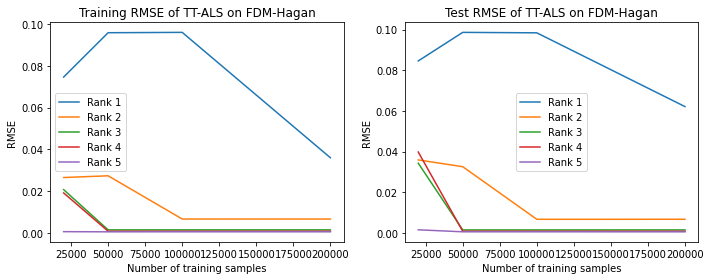

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for rank in range(1, 6):
    axes[0].plot([20000, 50000, 100000, 200000], hagan_test_results[rank-1,:,0,0], label=f"Rank {rank}")
    axes[1].plot([20000, 50000, 100000, 200000], hagan_test_results[rank-1,:,0,1], label=f"Rank {rank}")
for ax in axes:
    ax.legend()
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM-Hagan")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM-Hagan")
plt.tight_layout()

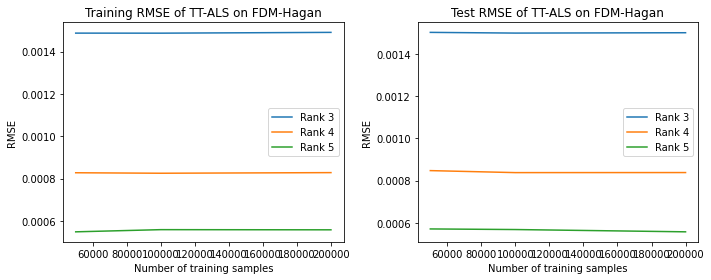

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for rank in range(3, 6):
    axes[0].plot([50000, 100000, 200000], hagan_test_results[rank-1,1:,0,0], label=f"Rank {rank}")
    axes[1].plot([50000, 100000, 200000], hagan_test_results[rank-1,1:,0,1], label=f"Rank {rank}")
for ax in axes:
    ax.legend()
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM-Hagan")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM-Hagan")
plt.tight_layout()

In [12]:
if use_cached_test_results:
    hagan_timed_results = np.load("hagan_timed_results.npy")
else:
    hagan_timed_results = np.array([run_test(HaganDiffModel(rank), 100000, data_train, timed=True) for rank in range(1, 11)])
    np.save("hagan_timed_results.npy", hagan_timed_results)

Testing HaganDiffModel(rank = 1) on 100000 samples
Testing HaganDiffModel(rank = 2) on 100000 samples
Testing HaganDiffModel(rank = 3) on 100000 samples
Testing HaganDiffModel(rank = 4) on 100000 samples
Testing HaganDiffModel(rank = 5) on 100000 samples
Testing HaganDiffModel(rank = 6) on 100000 samples
Testing HaganDiffModel(rank = 7) on 100000 samples
Testing HaganDiffModel(rank = 8) on 100000 samples
Testing HaganDiffModel(rank = 9) on 100000 samples
Testing HaganDiffModel(rank = 10) on 100000 samples


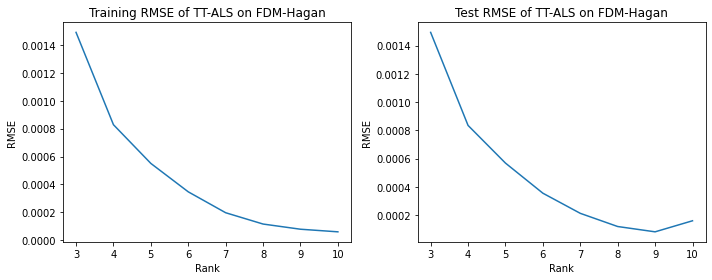

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(range(3, 11), hagan_timed_results[2:,0,0])
axes[1].plot(range(3, 11), hagan_timed_results[2:,0,1])
for ax in axes:
    ax.set_xlabel("Rank")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM-Hagan")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM-Hagan")
plt.tight_layout()

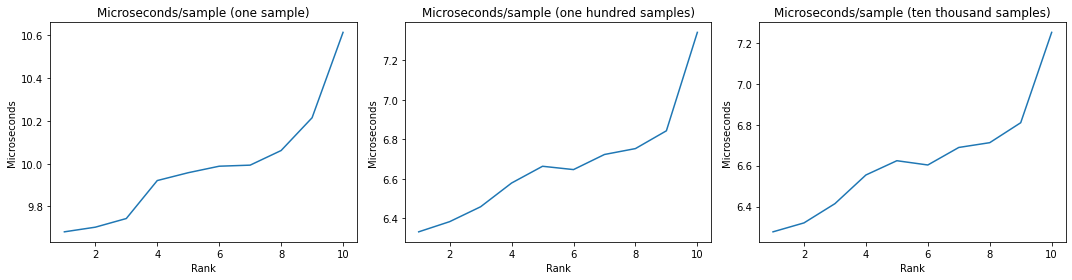

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].plot(range(1, 11), hagan_timed_results[:,1,0] * 10**6)
axes[1].plot(range(1, 11), hagan_timed_results[:,1,1] * 10**4)
axes[2].plot(range(1, 11), hagan_timed_results[:,1,2] * 10**2)
for ax in axes:
    ax.set_xlabel("Rank")
    ax.set_ylabel("Microseconds")
axes[0].title.set_text("Microseconds/sample (one sample)")
axes[1].title.set_text("Microseconds/sample (one hundred samples)")
axes[2].title.set_text("Microseconds/sample (ten thousand samples)")
plt.tight_layout()

In [15]:
if use_cached_test_results:
    fdm_test_results = np.load("fdm_test_results.npy")
else:
    fdm_test_results = np.array([[run_test(FdmModel(rank), num_samples, data_train) for num_samples in [20000, 50000, 100000, 200000]] for rank in range(1, 6)])
    np.save("fdm_test_results.npy", fdm_test_results)

Testing FdmModel(rank = 1) on 20000 samples
Testing FdmModel(rank = 1) on 50000 samples
Testing FdmModel(rank = 1) on 100000 samples
Testing FdmModel(rank = 1) on 200000 samples
Testing FdmModel(rank = 2) on 20000 samples
Testing FdmModel(rank = 2) on 50000 samples
Testing FdmModel(rank = 2) on 100000 samples
Testing FdmModel(rank = 2) on 200000 samples
Testing FdmModel(rank = 3) on 20000 samples
Testing FdmModel(rank = 3) on 50000 samples
Testing FdmModel(rank = 3) on 100000 samples
Testing FdmModel(rank = 3) on 200000 samples
Testing FdmModel(rank = 4) on 20000 samples
Testing FdmModel(rank = 4) on 50000 samples
Testing FdmModel(rank = 4) on 100000 samples
Testing FdmModel(rank = 4) on 200000 samples
Testing FdmModel(rank = 5) on 20000 samples
Testing FdmModel(rank = 5) on 50000 samples
Testing FdmModel(rank = 5) on 100000 samples
Testing FdmModel(rank = 5) on 200000 samples


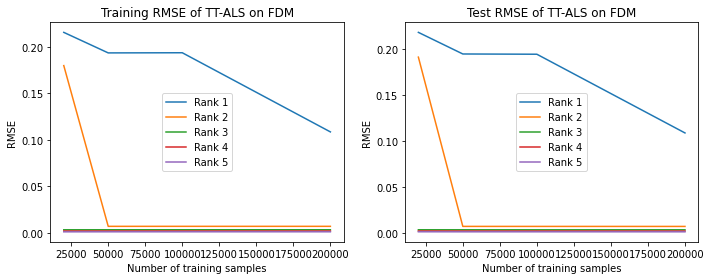

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for rank in range(1, 6):
    axes[0].plot([20000, 50000, 100000, 200000], fdm_test_results[rank-1,:,0,0], label=f"Rank {rank}")
    axes[1].plot([20000, 50000, 100000, 200000], fdm_test_results[rank-1,:,0,1], label=f"Rank {rank}")
for ax in axes:
    ax.legend()
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM")
plt.tight_layout()

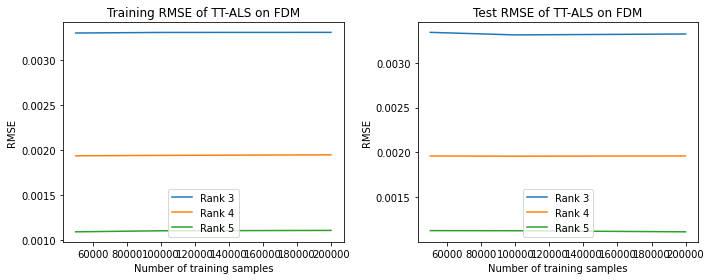

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for rank in range(3, 6):
    axes[0].plot([50000, 100000, 200000], fdm_test_results[rank-1,1:,0,0], label=f"Rank {rank}")
    axes[1].plot([50000, 100000, 200000], fdm_test_results[rank-1,1:,0,1], label=f"Rank {rank}")
for ax in axes:
    ax.legend()
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM")
plt.tight_layout()

In [18]:
if use_cached_test_results:
    fdm_timed_results = np.load("fdm_timed_results.npy")
else:
    fdm_timed_results = np.array([run_test(FdmModel(rank), 100000, data_train, timed=True) for rank in range(1, 11)])
    np.save("fdm_timed_results.npy", fdm_timed_results)

Testing FdmModel(rank = 1) on 100000 samples
Testing FdmModel(rank = 2) on 100000 samples
Testing FdmModel(rank = 3) on 100000 samples
Testing FdmModel(rank = 4) on 100000 samples
Testing FdmModel(rank = 5) on 100000 samples
Testing FdmModel(rank = 6) on 100000 samples
Testing FdmModel(rank = 7) on 100000 samples
Testing FdmModel(rank = 8) on 100000 samples
Testing FdmModel(rank = 9) on 100000 samples
Testing FdmModel(rank = 10) on 100000 samples


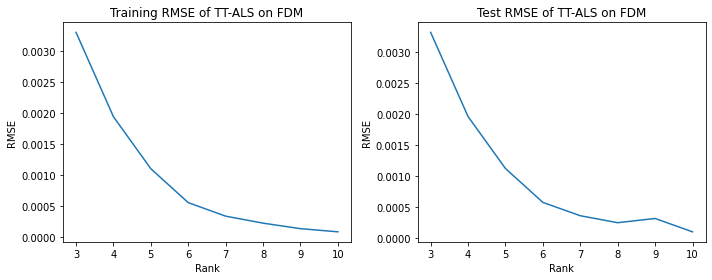

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(range(3, 11), fdm_timed_results[2:,0,0])
axes[1].plot(range(3, 11), fdm_timed_results[2:,0,1])
for ax in axes:
    ax.set_xlabel("Rank")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM")
plt.tight_layout()

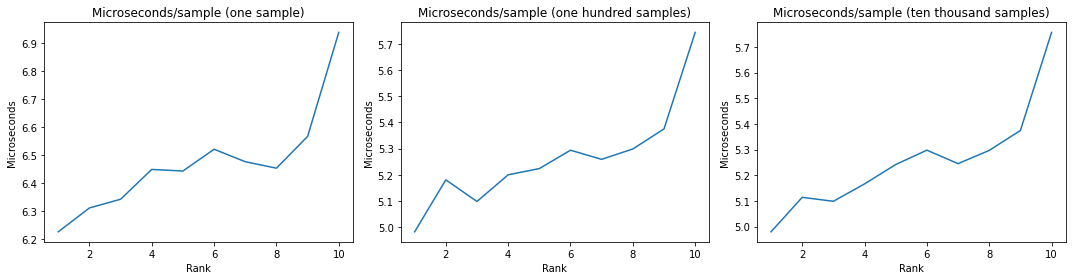

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].plot(range(1, 11), fdm_timed_results[:,1,0] * 10**6)
axes[1].plot(range(1, 11), fdm_timed_results[:,1,1] * 10**4)
axes[2].plot(range(1, 11), fdm_timed_results[:,1,2] * 10**2)
for ax in axes:
    ax.set_xlabel("Rank")
    ax.set_ylabel("Microseconds")
axes[0].title.set_text("Microseconds/sample (one sample)")
axes[1].title.set_text("Microseconds/sample (one hundred samples)")
axes[2].title.set_text("Microseconds/sample (ten thousand samples)")
plt.tight_layout()

In [21]:
polynomial_degree_sets = [
    [6, 12, 9, 11, 9, 9],
    [6, 11, 8, 10, 8, 8],
    [5, 10, 7, 9, 7, 7],
    [4, 8, 6, 7, 6, 6]
]
if use_cached_test_results:
    hagan_poly_test_results = np.load("hagan_poly_test_results.npy")
else:
    hagan_poly_test_results = np.array([[
        run_test(HaganPolynomialModel(rank, polynomial_degrees), 100000, data_train, data_test, timed=True)
        for rank in [6, 8, 10]
    ] for polynomial_degrees in polynomial_degree_sets])
    np.save("hagan_poly_test_results.npy", hagan_poly_test_results)

Testing HaganPolynomialModel(rank = 6, polynomial_degrees = [6, 12, 9, 11, 9, 9]) on 100000 samples
Testing HaganPolynomialModel(rank = 8, polynomial_degrees = [6, 12, 9, 11, 9, 9]) on 100000 samples
Testing HaganPolynomialModel(rank = 10, polynomial_degrees = [6, 12, 9, 11, 9, 9]) on 100000 samples
Testing HaganPolynomialModel(rank = 6, polynomial_degrees = [6, 11, 8, 10, 8, 8]) on 100000 samples
Testing HaganPolynomialModel(rank = 8, polynomial_degrees = [6, 11, 8, 10, 8, 8]) on 100000 samples
Testing HaganPolynomialModel(rank = 10, polynomial_degrees = [6, 11, 8, 10, 8, 8]) on 100000 samples
Testing HaganPolynomialModel(rank = 6, polynomial_degrees = [5, 10, 7, 9, 7, 7]) on 100000 samples
Testing HaganPolynomialModel(rank = 8, polynomial_degrees = [5, 10, 7, 9, 7, 7]) on 100000 samples
Testing HaganPolynomialModel(rank = 10, polynomial_degrees = [5, 10, 7, 9, 7, 7]) on 100000 samples
Testing HaganPolynomialModel(rank = 6, polynomial_degrees = [4, 8, 6, 7, 6, 6]) on 100000 samples
Te

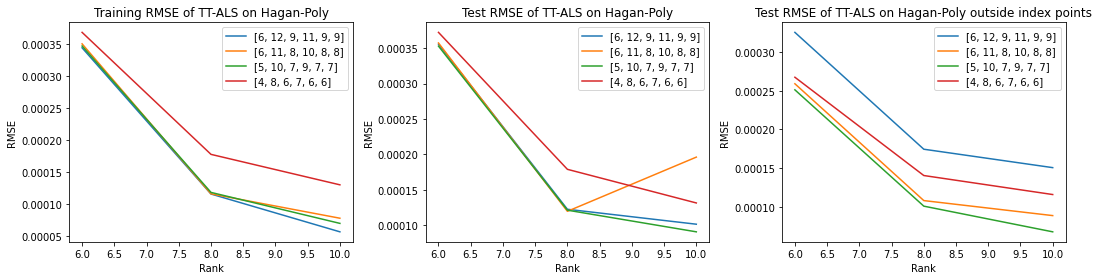

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i in range(4):
    axes[0].plot([6, 8, 10], hagan_poly_test_results[i,:,0,0], label=polynomial_degree_sets[i])
    axes[1].plot([6, 8, 10], hagan_poly_test_results[i,:,0,1], label=polynomial_degree_sets[i])
    axes[2].plot([6, 8, 10], hagan_poly_test_results[i,:,0,2], label=polynomial_degree_sets[i])
for ax in axes:
    ax.legend()
    ax.set_xlabel("Rank")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on Hagan-Poly")
axes[1].title.set_text("Test RMSE of TT-ALS on Hagan-Poly")
axes[2].title.set_text("Test RMSE of TT-ALS on Hagan-Poly outside index points")
plt.tight_layout()

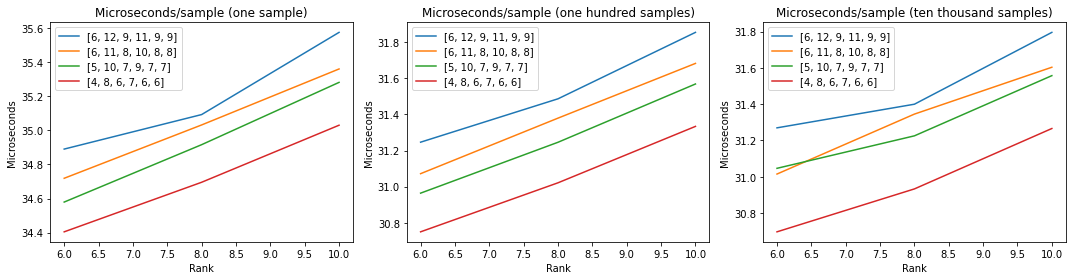

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i in range(4):
    axes[0].plot([6, 8, 10], hagan_poly_test_results[i,:,1,0] * 10**6, label=polynomial_degree_sets[i])
    axes[1].plot([6, 8, 10], hagan_poly_test_results[i,:,1,1] * 10**4, label=polynomial_degree_sets[i])
    axes[2].plot([6, 8, 10], hagan_poly_test_results[i,:,1,2] * 10**2, label=polynomial_degree_sets[i])
for ax in axes:
    ax.legend()
    ax.set_xlabel("Rank")
    ax.set_ylabel("Microseconds")
axes[0].title.set_text("Microseconds/sample (one sample)")
axes[1].title.set_text("Microseconds/sample (one hundred samples)")
axes[2].title.set_text("Microseconds/sample (ten thousand samples)")
plt.tight_layout()